In [1]:
#github link
#https://github.com/DavidN0809/ML-Biomed

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plotter_lib

pin_memory=False 

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


In [5]:
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#pil verison fix
import PIL

from PIL import __version__
print(__version__)

from PIL import __version__
PIL.PILLOW_VERSION = __version__

print(PIL.PILLOW_VERSION)


True
NVIDIA GeForce RTX 3070 Laptop GPU
cuda
9.0.1
9.0.1


In [6]:
import torchvision
torchvision.__version__  

'0.14.1+cu117'

In [7]:
# Define the data transforms to be applied to the images
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []
        for data_type in ['train', 'test']:
            for class_name in ['DME', 'DRUSEN']:
                class_path = os.path.join(self.root_dir, data_type, class_name)
                class_label = 1 if class_name == 'DME' else 0
                
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(class_label)
                    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            if 'train' in image_path:
                image = TF.resize(image, (32, 32))
            image = self.transform(image)
            
        return image, label


In [11]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train_dir='./Data/'
test_dir='./Data/'


#loading all images from the train and test directorys
image_datasets = {
        'train': 
CustomDataset(root_dir=train_dir, transform=train_transforms),
        'test': 
CustomDataset(root_dir=test_dir, transform=test_transforms)
}
from torch.utils.data import random_split

# create a validation set from the test set
val_size = int(len(image_datasets['test']) * 0.1) # use 10% of the test set for validation
test_size = len(image_datasets['test']) - val_size

test_dataset, val_dataset = random_split(image_datasets['test'], [test_size, val_size])

#loading all images from the train and test directorys
dataloaders = {
    'train': 
DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=os.cpu_count()),    
    'test': 
DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count()),
     'val':
DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())
}


#appending val for use in mode
image_datasets['val'] = val_dataset

# Get image and label from test data loader
images, labels = next(iter(dataloaders['test']))

# Print the shape of the image tensor and label tensor
print(f"Image shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


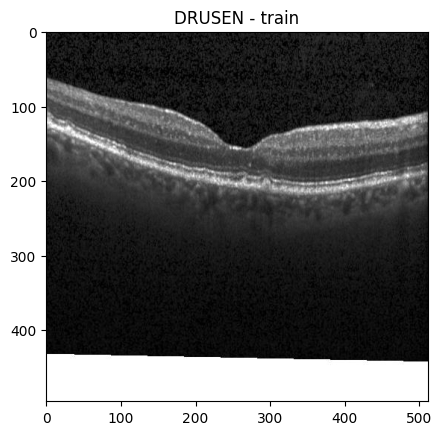

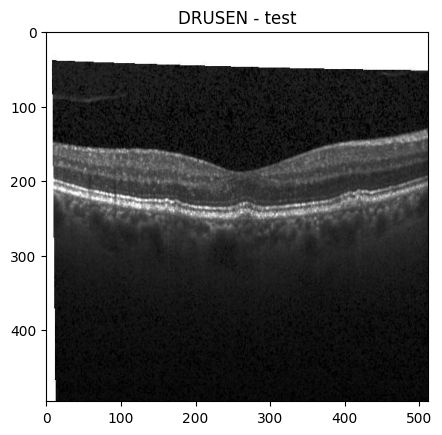

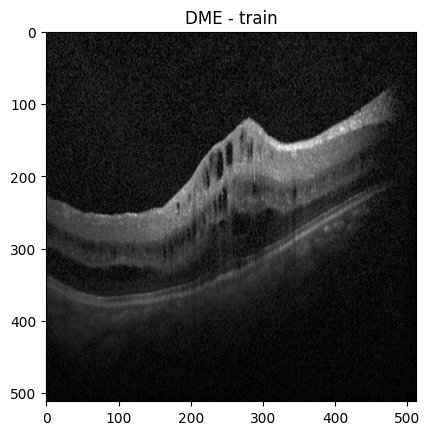

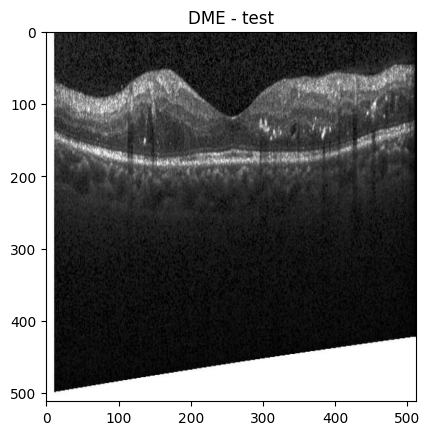

In [12]:
import matplotlib.pyplot as plt

# Define the path to the data directory
data_dir = './Data/'

# Define the class names
class_names = ['DRUSEN', 'DME']

# Define the split names
split_names = ['train', 'test']

# Iterate over the class names and split names
for class_name in class_names:
    for split_name in split_names:
        # Define the path to the image directory
        image_dir = os.path.join(data_dir, split_name, class_name)
        
        # Get the list of image file paths
        image_files = os.listdir(image_dir)
        
        # Load the first image from the directory
        image_file = os.path.join(image_dir, image_files[0])
        image = Image.open(image_file)
        
        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title(f"{class_name} - {split_name}")
        plt.show()


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
#checking if gpu is enabled

device(type='cuda', index=0)

In [14]:
#loading resnet50 model
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = True #unfreezing model   

#adding relu and linear layers 
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/home/david/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/david/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Lists to store values for plotting
acc_history = []
loss_history = []
f1_score_history = []
auc_history = []

import datetime
from sklearn import metrics
# Lists to store values for plotting
acc_history = []
loss_history = []
f1_score_history = []
auc_history = []

import datetime
from sklearn import metrics

def train_model(model, num_epochs=3, early_stop_patience=5, lr=1e-5):
    # Define the cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer using Adam and the specified learning rate
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    
    # Initialize the early stopping counter
    early_stop_counter = 0
    # Initialize the best validation loss and the corresponding model
    best_val_loss = float('inf')
    best_model = model

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Loop over the training and validation phases
        for phase in ['train', 'val']:
            # If in training phase, set the model to train mode
            if phase == 'train':
                model.train()
            # If in validation phase, set the model to evaluation mode
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Initialize variables for f1 score and auc
            y_pred = []
            y_true = []

            start_time = datetime.datetime.now()
            
            # Loop over the data in the dataloader for the current phase
            for inputs, labels in dataloaders[phase]:
                # Move the inputs and labels to the specified device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # If in validation phase, set no_grad
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                # Calculate the loss using the criterion
                loss = criterion(outputs, labels)

                # If in training phase, perform backpropagation and optimization step
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Get the predictions and calculate the number of correct predictions
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Append predictions and true labels for f1 score and auc calculations
                y_pred.append(torch.softmax(outputs, dim=1)[:, 1])
                y_true.append(labels)

            end_time = datetime.datetime.now()
            duration = end_time - start_time
            # Calculate the average loss and accuracy for the current epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Calculate f1 score and auc for the current epoch
            y_pred = torch.cat(y_pred).cpu().detach().numpy()
            y_true = torch.cat(y_true).cpu().detach().numpy()
            f1_score = metrics.f1_score(y_true, y_pred > 0.5)
            auc = metrics.roc_auc_score(y_true, y_pred)

            # Append the accuracy, loss, f1 score, and auc to the history list
            acc_history.append(epoch_acc.item())
            loss_history.append(epoch_loss)
            f1_score_history.append(f1_score)
            auc_history.append(auc)

        print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}, f1_score: {f1_score:.4f}, auc: {auc:.4f}, duration: {duration}', flush=True)

    return epoch, model


In [ ]:
#setting very high epochs so early stop will turn on
num_epochs=35
#tried 1e-4,1e-5 and 4e-5, 4e-5 got the best accuracy the quickest
lr=4e-5
#this was chosen due to 2 and 3 stopping too soon, and 5 never stopping
early=4

returned_epochs, model_trained = train_model(model,num_epochs,lr=lr, early_stop_patience=early)

Epoch 1/35
----------


In [ ]:
#%cd /content/drive/MyDrive/Github/
#%mkdir models
%cd /home/david/Documents/GitHub/ML-Biomed/midterm/
%mkdir models

In [ ]:
#saving model incase we need it later
torch.save(model_trained, './model/model_A.pt')

In [ ]:
# Initializing lists to store train and validation loss and accuracy history
train_loss_history = []
val_loss_history = []
val_acc_history = []
train_acc_history = []

# Looping through the zip of the loss_history, acc_history
# taking every 2nd item to separate train and validation history
for i, (train_loss, test_loss, test_acc, train_acc) in enumerate(zip(loss_history[0::2], loss_history[1::2], acc_history[0::2], acc_history[1::2])):
    # Appending train loss to the train_loss_history list
    train_loss_history.append(train_loss)
    # Appending validation loss to the val_loss_history list
    val_loss_history.append(test_loss)
    # Appending validation accuracy to the val_acc_history list
    # converting the value to CPU using .cpu() method
    val_acc_history.append(test_acc.cpu())
    # Appending train accuracy to the train_acc_history list
    # converting the value to CPU using .cpu() method
    train_acc_history.append(train_acc.cpu())

# Converting the lists to numpy arrays
train_loss_history = np.array(train_loss_history)
test_loss_history = np.array(val_loss_history)
test_acc_history = np.array(val_acc_history)
train_acc_history = np.array(train_acc_history)


In [ ]:
#creating range from epochs for plotting
epochs = range(1,returned_epochs+1)

In [ ]:
# Create a figure object with size and resolution specified
fig = plt.figure(figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')

# Plot training loss in green color and label it as "Training loss"
plt.plot(epochs, train_loss_history, 'g', label='Training loss')

# Plot validation loss in blue color and label it as "Validation loss"
plt.plot(epochs, test_loss_history, 'b', label='Validation loss')

# Set title for the plot
plt.title('Training and Validation loss Model A')

# Label x-axis as "Epochs"
plt.xlabel('Epochs')

# Label y-axis as "Loss"
plt.ylabel('Loss')

# Display legend for the plot
plt.legend()

# Save the plot to a file named 'Loss'
plt.savefig('Loss_Model_A')

# Display the plot
plt.show()


In [ ]:
# Plot accuracy history for training and validation sets
fig=plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k') # Create a figure with specified size and background color

plt.plot(epochs, train_acc_history, 'g', label='Training loss') # Plot the training accuracy history in green color
plt.plot(epochs, test_acc_history, 'b', label='Validation loss') # Plot the validation accuracy history in blue color

plt.title('Training and Validation Accuracy Model A') # Set the title of the plot
plt.xlabel('Epochs') # Set the x-axis label to 'Epochs'
plt.ylabel('Loss') # Set the y-axis label to 'Loss'
plt.legend() # Add the legend to the plot
plt.savefig("./figs/Accuracy_Model_A") # Save the plot to a file named 'Accuracy'
plt.grid() # Add a grid to the plot
plt.show() # Show the plot


In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model_trained.eval()

# Initialize variables to store metrics
accuracy = 0

# Initialize variables to store predictions and true labels
predictions = []
true_labels = []

# Iterate over the validation data
for inputs, labels in dataloaders['test']:
    # Move inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Pass data through the model
    with torch.no_grad():
        outputs = model(inputs)

    # Compute accuracy
    _, preds = torch.max(outputs, 1)
    accuracy += torch.sum(preds == labels.data)
    predictions.append(preds)
    true_labels.append(labels)

# Concatenate the predictions and true labels into a single array
predictions = torch.cat(predictions).cpu()
true_labels = torch.cat(true_labels).cpu()

# Calculate the average accuracy of the predictions
accuracy = accuracy.double() / len(val_dataset)
print('Test accuracy: {:.4f}'.format(accuracy))

# Compute the confusion matrix of the model
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using Seaborn
index_labels = ['True Label', 'False Label']
column_labels = ['Predicted True Label', 'Predicted False Label']
df_cm = pd.DataFrame(cm, index=index_labels, columns=column_labels)

# Set font size for the annotations in the confusion matrix
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})


In [ ]:
# Create a figure object with size and resolution specified
fig = plt.figure(figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')

# Plot f1 score in green color and label it as "F1 score"
plt.plot(epochs, f1_score_history, 'g', label='F1 score')

# Plot AUC in blue color and label it as "AUC"
plt.plot(epochs, auc_history, 'b', label='AUC')

# Set title for the plot
plt.title('F1 Score and AUC Model B')

# Label x-axis as "Epochs"
plt.xlabel('Epochs')

# Label y-axis as "Score"
plt.ylabel('Score')

# Display legend for the plot
plt.legend()

# Save the plot to a file named 'F1_AUC_Model_B'
plt.savefig('F1_AUC_Model_B')

# Display the plot
plt.show()
